# 5. Build a CNN model to identify the expression given the face

| Task                   | Sub-task                                | Comments                                  |
|------------------------|-----------------------------------------|-------------------------------------------|
| Data Preprocessing     | Scaling and Resizing                    | Done                                      |
|                        | Image Augmentation                      | Done                                      |
|                        | Train and test data handled correctly   | Done                                      |
|                        | Gaussian Blur, Histogram Equalization, and Intensity thresholds | Done |
| Model Trained          | Training Time?                         |     10 epochs in 3365 seconds                                 |
|                        | AUC and Confusion Matrix Computed      | Done                                      |
|  |Overfitting/Underfitting checked and handled| Done
| Empirical Tuning       | Interpretability Implemented           | Done                                      |
|                        | 1st Round of Tuning: Issue Faced: |  Initial model exhibited overfitting. Adjusted architecture, reducing complexity. Improved performance: reduced overfitting, better generalization. |


In [1]:
# !pip install tensorflow
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import os
import random
import cv2

In [2]:
# Define the directory containing your dataset
dataset_dir = 'dataset'

# Get the list of subfolders (class labels)
class_labels = os.listdir(dataset_dir)

# Count the number of images in each class
class_image_counts = {}
for label in class_labels:
    class_dir = os.path.join(dataset_dir, label)
    class_image_counts[label] = len(os.listdir(class_dir))

# Find the minimum number of images among all classes
min_images_per_class = min(class_image_counts.values())
print(min_images_per_class)

0


In [3]:
# Randomly select the minimum number of images from each class
selected_image_paths = []
for label in class_labels:
    class_dir = os.path.join(dataset_dir, label)
    image_files = os.listdir(class_dir)
    selected_images = random.sample(image_files, min_images_per_class)
    selected_image_paths.extend([os.path.join(class_dir, img) for img in selected_images])

In [4]:
# define the preprocessing function
def preprocess_image(image):
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.array(image, dtype=np.uint8)
    image = cv2.equalizeHist(image)
    _, image = cv2.threshold(image, 170, 255, cv2.THRESH_BINARY)
    return image

In [12]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda x: tf.image.random_brightness(x, 0.2),  # Adding brightness augmentation
    validation_split=0.2  # Splitting 20% of data for validation
)

In [13]:
# Define the ImageDataGenerator for training data (with augmentation)
train_generator = datagen.flow_from_directory(
    'dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use subset 'training' for training data
)

validation_generator = datagen.flow_from_directory(
    'dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use subset 'validation' for validation data
)

Found 12365 images belonging to 6 classes.
Found 3088 images belonging to 6 classes.


## Model1

In [15]:
# # Example usage
# image_path = r"C:\Users\ajitg\Downloads\a7efc835c926cbcf9877f90a237f4126.jpg"
# predicted_mood, confidence_score = predict_mood(image_path, model2)
# # Display the image
# img = image.load_img(image_path)
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# print("Predicted Mood:", predicted_mood)
# print("Confidence Score:", confidence_score)

## Model 2

In [16]:
# Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

In [17]:
# Model Training
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 64
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10
193/193 [==============================] - 417s 2s/step - loss: 1.5619 - accuracy: 0.3372 - val_loss: 1.4011 - val_accuracy: 0.4342
Epoch 2/10
193/193 [==============================] - 268s 1s/step - loss: 1.2865 - accuracy: 0.4564 - val_loss: 1.3549 - val_accuracy: 0.5111
Epoch 3/10
193/193 [==============================] - 248s 1s/step - loss: 1.1688 - accuracy: 0.5198 - val_loss: 1.3379 - val_accuracy: 0.4909
Epoch 4/10
193/193 [==============================] - 226s 1s/step - loss: 1.0971 - accuracy: 0.5486 - val_loss: 1.2492 - val_accuracy: 0.5033
Epoch 5/10
193/193 [==============================] - 232s 1s/step - loss: 1.0423 - accuracy: 0.5750 - val_loss: 1.1945 - val_accuracy: 0.5553
Epoch 6/10
193/193 [==============================] - 217s 1s/step - loss: 0.9856 - accuracy: 0.6014 - val_loss: 1.1121 - val_accuracy: 0.6224
Epoch 7/10
193/193 [==============================] - 280s 1s/step - loss: 0.9422 - accuracy: 0.6201 - val_loss: 1.0508 - val_accuracy: 0.6204

In [18]:
# Model Evaluation   
predictions = model.predict(validation_generator)
y_true = validation_generator.classes
y_pred = predictions.argmax(axis=1)

97/97 [==============================] - 58s 594ms/step


In [19]:
# Confusion Matrix
cm2 = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm2)

Confusion Matrix:
[[ 20  11  58  63  79  10]
 [ 15   8  64  67  94  14]
 [ 39  25 209 205 228  42]
 [ 50  29 202 205 277  42]
 [ 40  22 219 190 272  43]
 [ 11   4  67  66  82  16]]


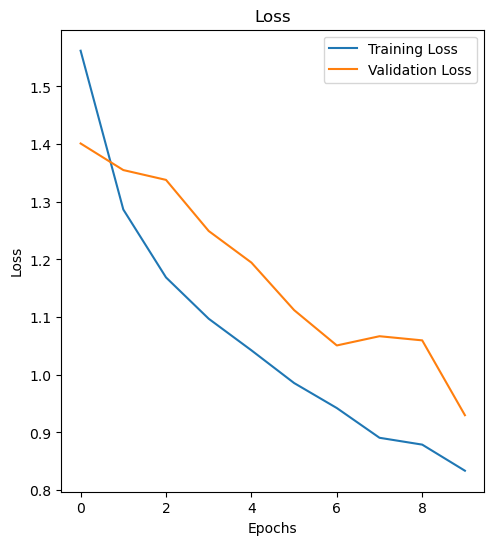

In [20]:
# Plotting training/validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


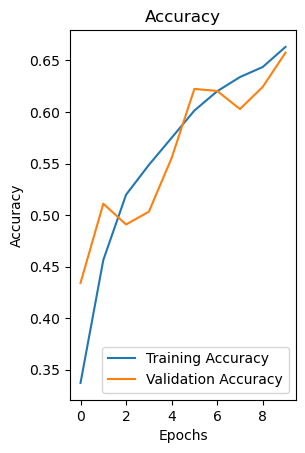

In [21]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
model.save('my_model.h5')

c:\Users\ajitg\projects\scraping\env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
from sklearn.metrics import roc_auc_score

# Compute AUC for each class
auc_scores = []
for i in range(len(predictions[0])):
    true_class = (y_true == i).astype(int)
    pred_prob_class = predictions[:, i]
    auc_score_class = roc_auc_score(true_class, pred_prob_class)
    auc_scores.append(auc_score_class)
# Print AUC scores for each class
for i, auc_score_class in enumerate(auc_scores):
    print(f"AUC for class {i}: {auc_score_class}")

AUC for class 0: 0.5078418426909304
AUC for class 1: 0.4861104358114131
AUC for class 2: 0.512293466337584
AUC for class 3: 0.4987357269366068
AUC for class 4: 0.5023654616076738
AUC for class 5: 0.5066611169278477


In [29]:
import cv2

from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to preprocess the image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Resize the image to match the input size of the model
    img = image.img_to_array(img)  # Convert image to numpy array
    img = cv2.GaussianBlur(img, (5, 5), 0)  # Apply Gaussian Blur
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img = img / 255.0  # Normalize pixel values
    return img

# Function to predict mood of the image
def predict_mood(image_path):
    # Preprocess the image
    img = preprocess_image(image_path)
    
    # Make predictions
    predictions = model.predict(img)
    
    # Interpret results
    predicted_class = np.argmax(predictions[0])  # Get the index of the class with highest probability
    mood_labels = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']  # Define mood labels
    predicted_mood = mood_labels[predicted_class]  # Get the predicted mood label
    
    # Get the confidence score of the prediction
    confidence_score = predictions[0][predicted_class]
    
    return predicted_mood, confidence_score

1/1 [==============================] - 0s 100ms/step


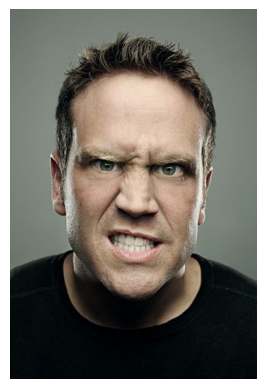

Predicted Mood: Angry
Confidence Score: 0.64730054


In [30]:
# Example usage
image_path = r"C:\Users\ajitg\Downloads\a7efc835c926cbcf9877f90a237f4126.jpg"
predicted_mood, confidence_score = predict_mood(image_path)
# Display the image
img = image.load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

print("Predicted Mood:", predicted_mood)
print("Confidence Score:", confidence_score)